# Balancing, transformations, and dimensionality reduction

In short, the main task is to play with balancing, binning, transformations, and dimensionality reduction to obtain the best results for the binary classification task.

## 1. Download the dataset, test_train_val split

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_log_error
import imblearn 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from sklearn.decomposition import PCA
from tqdm import tqdm

In [101]:
df = pd.read_csv('./data.csv')

In [3]:
df.head(5)

,y,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
0,0,2,1,5,1,6,0,1,0,0,...,4,0,2,8,0,0,0,1,1,0
1,0,2,1,6,0,0,0,0,0,1,...,9,2,3,7,0,0,1,0,0,0
2,0,2,1,9,0,0,1,0,0,0,...,5,0,2,6,0,1,0,1,1,0
3,0,1,1,6,0,0,1,0,0,0,...,3,0,4,8,0,0,1,0,0,0
4,0,1,1,5,1,0,0,1,0,0,...,4,3,1,2,0,1,0,0,1,0


In [4]:
y = list(df['y'])
X = df.drop(['y'],axis=1)

# train test val split in 60-20-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)

## 2. Binary classification

In [5]:
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'accuracy: {accuracy:.5f}, MAE: {mae:.5f}')

accuracy: 0.91711, MAE: 0.08289


## 3. Two binning methods & comparison

In [91]:
# let's find the some of the most correlated with target columns to try binning on them
pearson_correlation = df.corr()['y'].drop('y').abs().sort_values(ascending=False)
print(pearson_correlation[:5])

xcar_13        0.053899
xcar_12        0.038790
xind_17_bin    0.037053
xcar_07_cat    0.036395
xreg_02        0.034800
Name: y, dtype: float64


3.1 Equal width binning

count    595212.000000
mean          0.813265
std           0.224588
min           0.250619
25%           0.670867
50%           0.765811
75%           0.906190
max           3.720626
Name: xcar_13, dtype: float64

<Axes: >

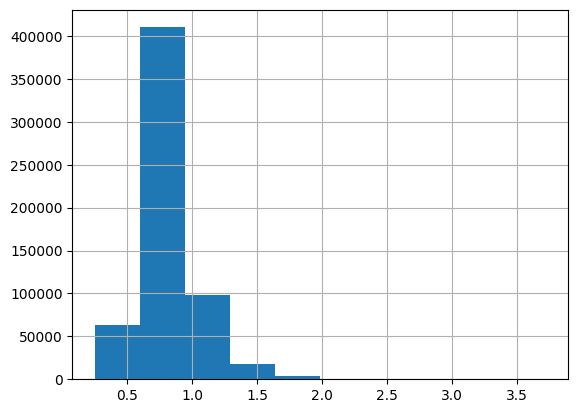

In [92]:
display(df['xcar_13'].describe())
df['xcar_13'].hist()

In [93]:
# we will have 6 bins of equal width
bins = np.linspace(df['xcar_13'].min(), df['xcar_13'].max(), 7)
print(bins)
bins_names = [1, 2, 3, 4, 5, 6]

[0.25061907 0.82895356 1.40728805 1.98562254 2.56395702 3.14229151
 3.720626  ]


<Axes: >

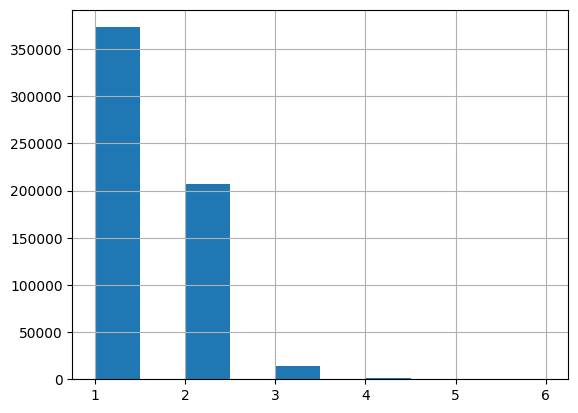

In [94]:
df['ew_bins_13'] = pd.cut(df['xcar_13'], bins, labels=bins_names)
df['ew_bins_13'].hist()

3.2 Equal depth binning

<Axes: >

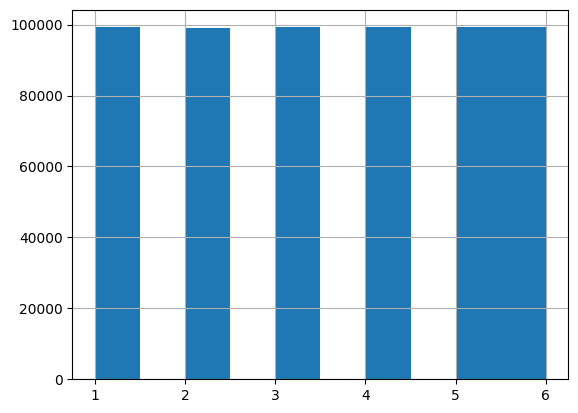

In [95]:
df['ed_bins_13'], bins = pd.qcut(df['xcar_13'], 6, labels=bins_names, retbins=True)
df['ed_bins_13'].hist()

Let's do binning on some other data 'xcar_12' and 'xcar_07_cat'

<Axes: >

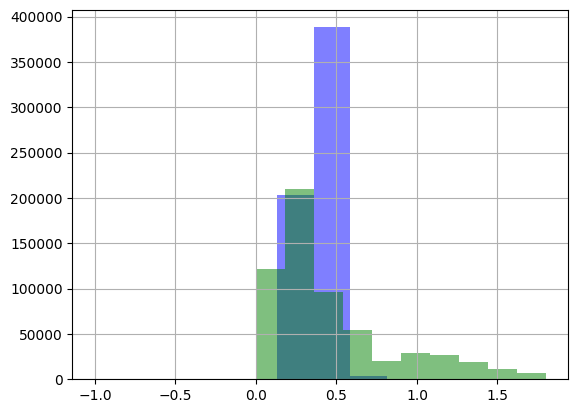

In [96]:
df['xcar_12'].hist(color='blue', alpha=0.5)
df['xreg_02'].hist(color='green', alpha=0.5)

In [97]:
bins = np.linspace(df['xcar_12'].min(), df['xcar_12'].max(), 5)
bins_names = [1, 2, 3, 4]
df['ew_bins_12'], bins = pd.cut(df['xcar_12'], 4, labels=bins_names, retbins=True)
df['ed_bins_12'], bins = pd.qcut(df['xcar_12'], 4, labels=bins_names, retbins=True)

bins = np.linspace(df['xreg_02'].min(), df['xreg_02'].max(), 6)
bins_names = [1, 2, 3, 4, 5]
df['ew_xreg_02'], bins = pd.cut(df['xreg_02'], 5, labels=bins_names, retbins=True)
df['ed_xreg_02'], bins = pd.qcut(df['xreg_02'], 5, labels=bins_names, retbins=True)

In [98]:
df.columns

Index(['y', 'xind_01', 'xind_02_cat', 'xind_03', 'xind_04_cat', 'xind_05_cat',
       'xind_06_bin', 'xind_07_bin', 'xind_08_bin', 'xind_09_bin',
       'xind_10_bin', 'xind_11_bin', 'xind_12_bin', 'xind_13_bin', 'xind_14',
       'xind_15', 'xind_16_bin', 'xind_17_bin', 'xind_18_bin', 'xreg_01',
       'xreg_02', 'xreg_03', 'xcar_01_cat', 'xcar_02_cat', 'xcar_03_cat',
       'xcar_04_cat', 'xcar_05_cat', 'xcar_06_cat', 'xcar_07_cat',
       'xcar_08_cat', 'xcar_09_cat', 'xcar_10_cat', 'xcar_11_cat', 'xcar_11',
       'xcar_12', 'xcar_13', 'xcar_14', 'xcar_15', 'xcalc_01', 'xcalc_02',
       'xcalc_03', 'xcalc_04', 'xcalc_05', 'xcalc_06', 'xcalc_07', 'xcalc_08',
       'xcalc_09', 'xcalc_10', 'xcalc_11', 'xcalc_12', 'xcalc_13', 'xcalc_14',
       'xcalc_15_bin', 'xcalc_16_bin', 'xcalc_17_bin', 'xcalc_18_bin',
       'xcalc_19_bin', 'xcalc_20_bin', 'ew_bins_13', 'ed_bins_13',
       'ew_bins_12', 'ed_bins_12', 'ew_xreg_02', 'ed_xreg_02'],
      dtype='object')

In [99]:
# original data - train-test plit, model initialization, metrics - once again for easier comparion with other variants
y = list(df['y'])
X = df.drop(['y','ew_bins_13', 'ed_bins_13', 'ed_bins_12', 'ed_bins_12', 'ew_xreg_02', 'ed_xreg_02'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'Original data: \naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')

# xcar_12 equal width - train-test plit, model initialization, metrics
X = df.drop(['y', 'ew_bins_13', 'ed_bins_13', 'xcar_12','ed_bins_12', 'ew_xreg_02', 'ed_xreg_02'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'xcar_12 equal width: \naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')

# xcar_12 equal depth - train-test plit, model initialization, metrics
X = df.drop(['y', 'ew_bins_13', 'ed_bins_13', 'xcar_12', 'ew_bins_12', 'ew_xreg_02', 'ed_xreg_02'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'xcar_12 equal depth: \naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')

# xreg_02 equal width - train-test plit, model initialization, metrics
X = df.drop(['y', 'ew_bins_13', 'ed_bins_13', 'ew_bins_12', 'ed_bins_12', 'ed_xreg_02', 'xreg_02'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'xreg_02 equal width: \naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')

# xreg_02 equal depth - train-test plit, model initialization, metrics
X = df.drop(['y', 'ew_bins_13', 'ed_bins_13', 'ew_bins_12', 'ed_bins_12', 'ew_xreg_02', 'xreg_02'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'xreg_02 equal depth: \naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')

Original data: 
accuracy: 0.9182758003, MAE: 0.0817241997
xcar_12 equal width: 
accuracy: 0.9177997805, MAE: 0.0822002195
xcar_12 equal depth: 
accuracy: 0.9184718084, MAE: 0.0815281916
xreg_02 equal width: 
accuracy: 0.9181301942, MAE: 0.0818698058
xreg_02 equal depth: 
accuracy: 0.9183430031, MAE: 0.0816569969


We can see that with binning the metrics stayed almost the same. Binning does not always provide much better results as a must. The best approach was xreg_02 equal depth binning.

## 4. Two data balancing techniques

4.1 Random under-sampling of imbalaced data

In [15]:
# cleaning the bins columns - creating our original raw dataset
df = df.drop(columns=['ew_bins_13', 'ed_bins_13',
       'ew_bins_12', 'ed_bins_12', 'ew_xreg_02', 'ed_xreg_02'])
df.columns

Index(['y', 'xind_01', 'xind_02_cat', 'xind_03', 'xind_04_cat', 'xind_05_cat',
       'xind_06_bin', 'xind_07_bin', 'xind_08_bin', 'xind_09_bin',
       'xind_10_bin', 'xind_11_bin', 'xind_12_bin', 'xind_13_bin', 'xind_14',
       'xind_15', 'xind_16_bin', 'xind_17_bin', 'xind_18_bin', 'xreg_01',
       'xreg_02', 'xreg_03', 'xcar_01_cat', 'xcar_02_cat', 'xcar_03_cat',
       'xcar_04_cat', 'xcar_05_cat', 'xcar_06_cat', 'xcar_07_cat',
       'xcar_08_cat', 'xcar_09_cat', 'xcar_10_cat', 'xcar_11_cat', 'xcar_11',
       'xcar_12', 'xcar_13', 'xcar_14', 'xcar_15', 'xcalc_01', 'xcalc_02',
       'xcalc_03', 'xcalc_04', 'xcalc_05', 'xcalc_06', 'xcalc_07', 'xcalc_08',
       'xcalc_09', 'xcalc_10', 'xcalc_11', 'xcalc_12', 'xcalc_13', 'xcalc_14',
       'xcalc_15_bin', 'xcalc_16_bin', 'xcalc_17_bin', 'xcalc_18_bin',
       'xcalc_19_bin', 'xcalc_20_bin'],
      dtype='object')

In [16]:
def accuracy_balancing(df):
    # defining the sampler
    y = list(df['y'])
    X = df.drop(['y'],axis=1)

    # model
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1)
    tree = DecisionTreeClassifier()
    y_pred = tree.fit(X_train, y_train).predict(X_test)

    # defining accuracy
    confusionmatrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print('true Positive: ', tp)
    print('false Positive: ', fp)
    print('true Negative: ', tn)
    print('false Negative: ', fn)

    # calculate accuracy using confusion matrix
    accuracy =  (tp + tn) / (tp + fp + tn + fn)
    return accuracy

In [24]:
# original dataset
print('original dataset: ')
accuracy = accuracy_balancing(df)
# check shape!
print('oriniginal dataset:', Counter(y))
print(f'original dataset: \naccuracy: {accuracy:.10f}')

# under sampling
usampler = RandomUnderSampler(random_state=1, replacement=True)
y = list(df['y'])
X = df.drop(['y'],axis=1)
X_undersam, y_undersam = usampler.fit_resample(X, y)

print('under sampling: ')
df_undersam = X_undersam
df_undersam['y'] = y_undersam
accuracy = accuracy_balancing(df_undersam)
# check shape
print('balanced dataset using random under sampling: ', Counter(y_undersam))
print(f'random under sampling balancing: \naccuracy: {accuracy:.10f}')

original dataset: 
true Positive:  403
false Positive:  8645
true Negative:  163418
false Negative:  6098
oriniginal dataset: Counter({0: 573518, 1: 21694})
original dataset: 
accuracy: 0.9174357653
under sampling: 
true Positive:  3350
false Positive:  3017
true Negative:  3518
false Negative:  3132
balanced dataset using random under sampling:  Counter({0: 21694, 1: 21694})
random under sampling balancing: 
accuracy: 0.5276177307


We can see the accuaracy droppped, so we can confirm that random undersampling method is not the best decision for our data

4.2 Nearmiss - one more undersampling balancing technique

In [18]:
from imblearn.under_sampling import NearMiss

In [23]:
# original dataset
print('original dataset: ')
accuracy = accuracy_balancing(df)
# check shape!
print('oriniginal dataset:', Counter(y))
print(f'original dataset: \naccuracy: {accuracy:.10f}')

# under sampling with NearMiss
nearmiss = NearMiss()
y = list(df['y'])
X = df.drop(['y'],axis=1)
X_undersam, y_undersam = nearmiss.fit_resample(X, y)

print('under sampling: ')
df_undersam = X_undersam
df_undersam['y'] = y_undersam
accuracy = accuracy_balancing(df_undersam)
# check shape
print('balanced dataset using nearmiss under sampling: ', Counter(y_undersam))
print(f'nearmiss under sampling balancing: \naccuracy: {accuracy:.10f}')

original dataset: 
true Positive:  416
false Positive:  8641
true Negative:  163422
false Negative:  6085
oriniginal dataset: Counter({0: 573518, 1: 21694})
original dataset: 
accuracy: 0.9175309693
under sampling: 
true Positive:  4686
false Positive:  1528
true Negative:  5007
false Negative:  1796
balanced dataset using nearmiss under sampling:  Counter({0: 21694, 1: 21694})
nearmiss under sampling balancing: 
accuracy: 0.7446416225


We can see the accuaracy droppped again, so we can confirm that nearmiss undersampling method is not the best decision for our data.

Let's try oversampling - maybe it will give us better results!

4.3 SMOTE - syntheric minority oversampling technique

In [22]:
# let's run the same pipeline once again

# original dataset
print('original dataset: ')
accuracy = accuracy_balancing(df)
# check shape!
print('oriniginal dataset:', Counter(y))
print(f'original dataset: \naccuracy: {accuracy:.10f}')

# under sampling with NearMiss

smote = SMOTE()
y = list(df['y'])
X = df.drop(['y'],axis=1)
X_undersam, y_undersam = smote.fit_resample(X, y)
print('under sampling: ')
df_undersam = X_undersam
df_undersam['y'] = y_undersam
accuracy = accuracy_balancing(df_undersam)
# check shape
print('balanced dataset SMOTE over sampling: ', Counter(y_undersam))
print(f'SMOTE over sampling balancing: \naccuracy: {accuracy:.10f}')

original dataset: 
true Positive:  408
false Positive:  8533
true Negative:  163530
false Negative:  6093
oriniginal dataset: Counter({0: 573518, 1: 21694})
original dataset: 
accuracy: 0.9180909926
under sampling: 
true Positive:  164066
false Positive:  12458
true Negative:  159787
false Negative:  7800
balanced dataset SMOTE over sampling:  Counter({0: 573518, 1: 573518})
SMOTE over sampling balancing: 
accuracy: 0.9411294611


Finally, some not terrible results:) The accuracy with oversampling - SMOTE - even improved. Safe to confirm - for this case oversampling with SMOTE is the best method of balancing. (at least out of those we tried)

## 5. Feature engineering

In [25]:
df.isna().sum().sum()

0

<Axes: >

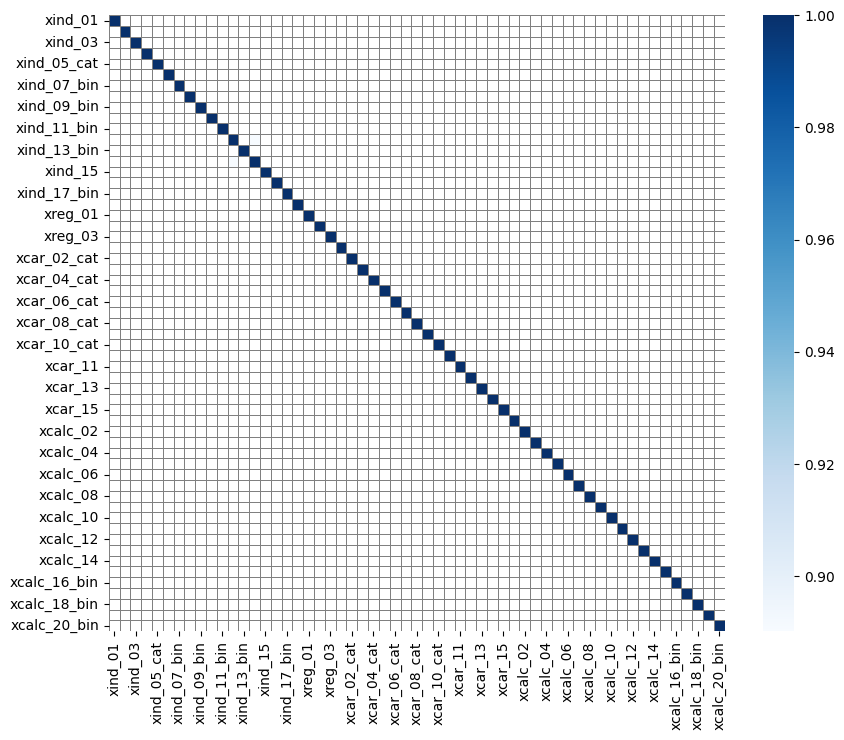

In [26]:
# no missing values.
# let's check for multicolinearity
corrmat = df.drop(columns='y').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat,mask=corrmat<0.75,linewidth=0.5,cmap="Blues", square=True, linecolor='grey')

No columns represent the same information, so let's go to other methods.

In [27]:
# normalize the data after test train split
y = list(df['y'])
X = df.drop(['y'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_scaled, y_train).predict(X_test_scaled)
accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'\naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')


accuracy: 0.9185334110, MAE: 0.0814665890


The scaling helped a bit.

In [30]:
df['xcar_01_cat'].unique()

array([ 7,  6, 10, 11,  8,  5,  9,  2,  4,  3,  0,  1, -1], dtype=int64)

we could one hot encode the categorical columns, but there is no need - they are already numbers.

In [ ]:
# # let's try introducing polynomial features to try capture more coplex patterns
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.transform(X_test)

# tree = DecisionTreeClassifier()
# tree.fit(X_train_poly, y_train)

# y_pred = tree.predict(X_test_poly)

# accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
# print(f'\naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')

Inroducing polynomial features did in fact not help our model. The algorithm has been running for too long and so even if the method would help, it required too much computatiion time and resources, so we will skip it.

## 6. Feature selection methods - we will already see the results of the approach - step 8 is incorporated. In 8 we will just combine appoaches

6.1 Lasso regression

In [58]:
# Lasso regression does L1 penalty that drives the coefficients of useless features to zero so we can easily get useful ones
y = list(df['y'])
X = df.drop(['y'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

lasso = Lasso(alpha=0.005, random_state=1)
lasso.fit(X_train, y_train)

# if the coefficient is not 0 - the feature is useful
selected_features = np.where(lasso.coef_ != 0)[0]
selected_column_names = X_train.columns[selected_features]

X_train_subset = X_train[selected_column_names]
X_test_subset = X_test[selected_column_names]

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_subset, y_train).predict(X_test_subset)
y_pred = tree.predict(X_test_subset)

accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'\naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')
print(f'our selected features are: {selected_column_names.tolist()}')


accuracy: 0.9526108286, MAE: 0.0473891714
our selected features are: ['xind_01', 'xind_05_cat', 'xind_15', 'xcar_01_cat', 'xcar_04_cat', 'xcar_06_cat', 'xcar_11_cat']


Using subsets with lasso our model's accuracy did in fact improve quite a lot. Let's try other methods.

6.2 K Best

In [60]:
# K Best simplifies feature selection by focusing on the k most influential features using a chosen scoring metric
y = list(df['y'])
X = df.drop(['y'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

k = 10 # usually need to cross validate but according to Loss 7 were good, so it is reasonable to try 10
selector = SelectKBest(score_func=f_regression, k=k)

# select the needed features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# create subsets
selected_column_names = X.columns[selector.get_support(indices=True)]
X_train_subset = X_train[selected_column_names]
X_test_subset = X_test[selected_column_names]

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_subset, y_train).predict(X_test_subset)

# Calculate metrics
accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'\naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')
print(f'0ur selected features are: {selected_column_names.tolist()}')


Accuracy: 0.9318395645, MAE: 0.0681604355
0ur selected features are: ['xind_06_bin', 'xind_07_bin', 'xind_17_bin', 'xreg_02', 'xcar_02_cat', 'xcar_03_cat', 'xcar_04_cat', 'xcar_07_cat', 'xcar_12', 'xcar_13']


K Best also provided better results, than the initial raw data. However, the results of Lasso were even a bit better.

## 7. PCA

In [69]:
# just to get our original metrics for the raw data
y = list(df['y'])
X = df.drop(['y'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
y_pred = tree.predict(X_test)

accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
print(f'\naccuracy: {accuracy:.10f}, MAE: {mae:.10f}')


accuracy: 0.9184550077, MAE: 0.0815449923


In [83]:
# pca for different components, for comparison with raw data results and between eachother
for component in range(1, 16):

    pca = PCA(n_components=component)

    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    X_train_copy = pca.fit_transform(X_train_copy)
    X_test_copy = pca.transform(X_test_copy)

    tree = DecisionTreeClassifier()
    y_pred = tree.fit(X_train_copy, y_train).predict(X_test_copy)

    accuracy, mae = accuracy_score(y_pred, y_test), mean_absolute_error(y_pred, y_test)
    
    print(f'number of components: {component}')
    print(f'accuracy: {accuracy:.10f}, MAE: {mae:.10f}', end='\n')

number of components: 1
accuracy: 0.9372045877, MAE: 0.0627954123
number of components: 2
accuracy: 0.9284458233, MAE: 0.0715541767
number of components: 3
accuracy: 0.9274433816, MAE: 0.0725566184
number of components: 4
accuracy: 0.9259985215, MAE: 0.0740014785
number of components: 5
accuracy: 0.9250408817, MAE: 0.0749591183
number of components: 6
accuracy: 0.9249680787, MAE: 0.0750319213
number of components: 7
accuracy: 0.9239824377, MAE: 0.0760175623
number of components: 8
accuracy: 0.9235680204, MAE: 0.0764319796
number of components: 9
accuracy: 0.9226383818, MAE: 0.0773616182
number of components: 10
accuracy: 0.9222631661, MAE: 0.0777368339
number of components: 11
accuracy: 0.9221175601, MAE: 0.0778824399
number of components: 12
accuracy: 0.9224535741, MAE: 0.0775464259
number of components: 13
accuracy: 0.9217759459, MAE: 0.0782240541
number of components: 14
accuracy: 0.9213895298, MAE: 0.0786104702
number of components: 15
accuracy: 0.9210199144, MAE: 0.0789800856


After running the model on different number of components, we can say that the best accuracy was actually at a 1 component - and it is better than the original one. That is good - we achive better results with so little computation.

## 8. Combine methods to achieve best results.

Let's at first rememeber our best working approaches:
- SMOTE did increase our metrics
- Lasso regression was also useful
- PCA with 1 did give us slightly better results
- scaling the data did also help us

Now we will encorporate it all, repeating some of the processes to get our metrics together.

In [126]:
accuracies = []

# raw
y = list(df['y'])
X = df.drop(['y'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
accuracies.append(accuracy)

# Scaling features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_scaled, y_train).predict(X_test_scaled)
accuracy = accuracy_score(y_pred, y_test)
accuracies.append(accuracy)

# Oversampling using SMOTE
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_resampled, y_train_resampled).predict(X_test_scaled)
accuracy = accuracy_score(y_pred, y_test)
accuracies.append(accuracy)

# Lasso feature selection
lasso = Lasso(alpha=0.005, random_state=1)
lasso.fit(X_train_scaled, y_train)

selected_features = np.where(lasso.coef_ != 0)[0]
selected_column_names = X.columns[selected_features]

X_train_subset = X_train[selected_column_names]
X_test_subset = X_test[selected_column_names]

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_subset, y_train).predict(X_test_subset)
accuracy = accuracy_score(y_pred, y_test)
accuracies.append(accuracy)

# PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_pca, y_train).predict(X_test_pca)
accuracy = accuracy_score(y_pred, y_test)
accuracies.append(accuracy)

In [127]:
accuracies

[0.9179677874599583,
 0.9176429739477162,
 0.9160021056875967,
 0.9374957998252728,
 0.9304899083801886]

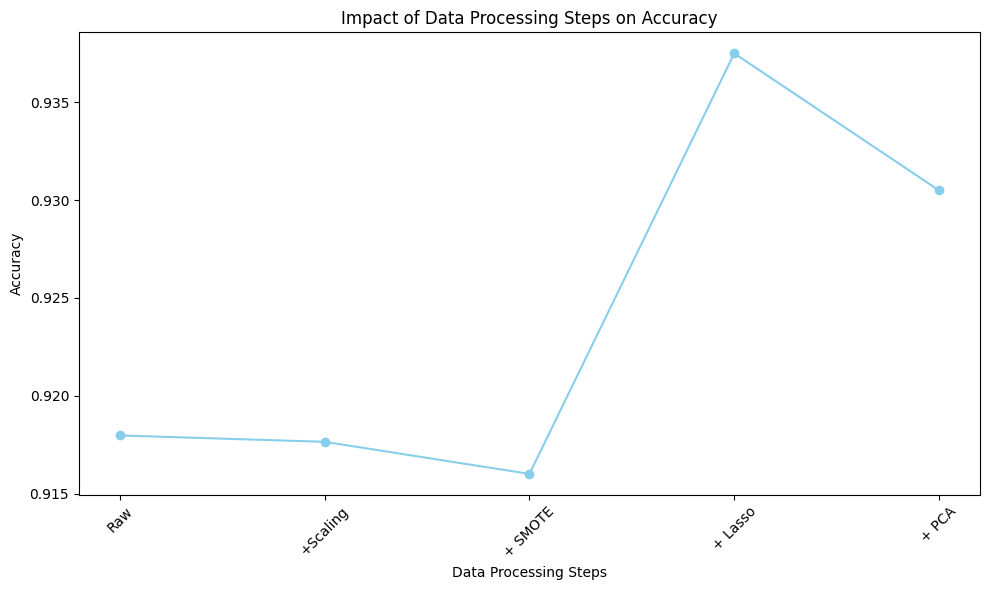

In [128]:
steps = ['Raw', '+Scaling', '+ SMOTE', '+ Lasso', '+ PCA']
plt.figure(figsize=(10, 6))
plt.plot(steps, accuracies, marker='o', linestyle='-', color='skyblue')

plt.xlabel('Data Processing Steps')
plt.ylabel('Accuracy')
plt.title('Impact of Data Processing Steps on Accuracy')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Looking at this graph we can easily detect the processing algorithm, that helped us improve our results the most. That was the Lasso regression feature selection.
That is also good news, as selecting as few features as possible, we can make our computation much easier. 
Let's now run the same pipeline, but do the feature selection at first.

In [141]:
new_accuracies = []

# raw
y = list(df['y'])
X = df.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
new_accuracies.append(accuracy)

# Lasso feature selection
lasso = Lasso(alpha=0.005, random_state=1)
lasso.fit(X_train, y_train)

selected_features = np.where(lasso.coef_ != 0)[0]
selected_column_names = X.columns[selected_features]

X_train_subset = X_train[selected_column_names]
X_test_subset = X_test[selected_column_names]

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_subset, y_train).predict(X_test_subset)
accuracy = accuracy_score(y_pred, y_test)
new_accuracies.append(accuracy)

# Scaling features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_test_subset)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_scaled, y_train).predict(X_test_scaled)
accuracy = accuracy_score(y_pred, y_test)
new_accuracies.append(accuracy)

# Oversampling using SMOTE
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_resampled, y_train_resampled).predict(X_test_scaled)
accuracy = accuracy_score(y_pred, y_test)
new_accuracies.append(accuracy)

# PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_pca, y_train).predict(X_test_pca)
accuracy = accuracy_score(y_pred, y_test)
new_accuracies.append(accuracy)

In [140]:
new_accuracies

[0.9525268251159248,
 0.9525884276785914,
 0.9250464819336485,
 0.9558925651307094]

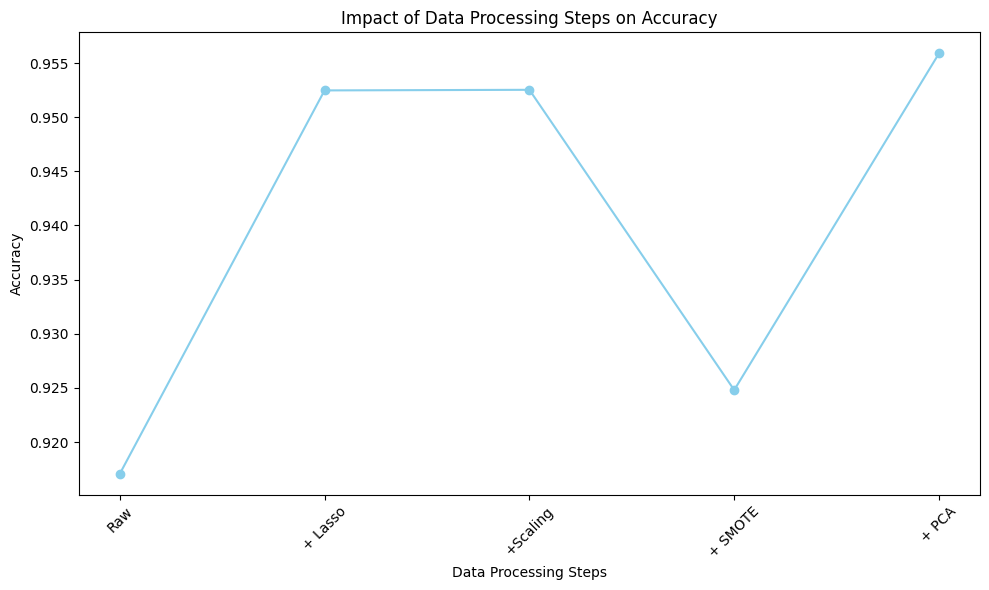

In [142]:
steps = ['Raw', '+ Lasso', '+Scaling', '+ SMOTE', '+ PCA']
plt.figure(figsize=(10, 6))
plt.plot(steps, new_accuracies, marker='o', linestyle='-', color='skyblue')

plt.xlabel('Data Processing Steps')
plt.ylabel('Accuracy')
plt.title('Impact of Data Processing Steps on Accuracy')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

That gave us even better results. Let's skip SMOTE now, just for the last try.

In [144]:
new2_accuracies = []

# raw
y = list(df['y'])
X = df.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train, y_train).predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
new2_accuracies.append(accuracy)

# Lasso feature selection
lasso = Lasso(alpha=0.005, random_state=1)
lasso.fit(X_train, y_train)

selected_features = np.where(lasso.coef_ != 0)[0]
selected_column_names = X.columns[selected_features]

X_train_subset = X_train[selected_column_names]
X_test_subset = X_test[selected_column_names]

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_subset, y_train).predict(X_test_subset)
accuracy = accuracy_score(y_pred, y_test)
new2_accuracies.append(accuracy)

# Scaling features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_test_subset)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_scaled, y_train).predict(X_test_scaled)
accuracy = accuracy_score(y_pred, y_test)
new2_accuracies.append(accuracy)

# PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

tree = DecisionTreeClassifier()
y_pred = tree.fit(X_train_pca, y_train).predict(X_test_pca)
accuracy = accuracy_score(y_pred, y_test)
new2_accuracies.append(accuracy)

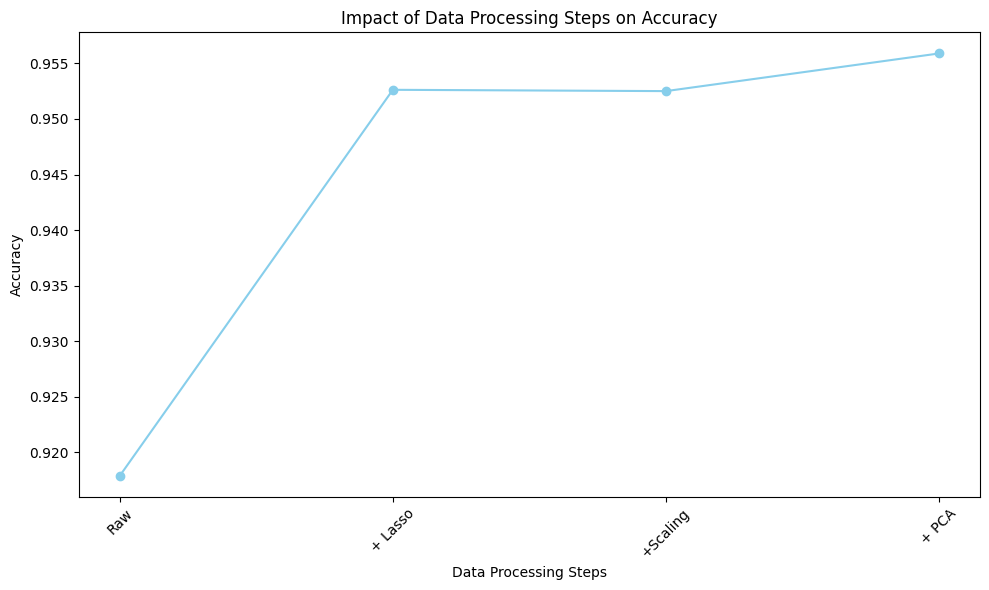

In [145]:
steps = ['Raw', '+ Lasso', '+Scaling', '+ PCA']
plt.figure(figsize=(10, 6))
plt.plot(steps, new2_accuracies, marker='o', linestyle='-', color='skyblue')

plt.xlabel('Data Processing Steps')
plt.ylabel('Accuracy')
plt.title('Impact of Data Processing Steps on Accuracy')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

At last, our approach created the best results. With all this we did impove our accuracy a lot.